In [1]:
import torch
import wandb
import os

from bayesian.models import HorseshoeSSVS
from bayesian.inference import inference
from bayesian.utils import plot_forecast
from ESN.utils import run_esn

import pyro

In [2]:
config = {
            "dataset": "acea",
            "model_widths": [20, 10, 1],
            "activation": "tanh",
            "distributions": ["gauss", "unif", "gauss"],
            "parameters": [[0,1],[0,10]],
            "dim_reduction": False,
            "inference": "mcmc",
            "plot": True
            }

os.environ["WANDB_MODE"]="offline"
wandb.init(project="bayes_rc", config=config)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]='0'

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

Run ESN on dataset and produce embeddings with or without dimensionality reduction according to `dim_reduction`

In [4]:
Ytr, train_embedding, val_embedding, Yte, test_embedding = run_esn(config.dataset, device, dim_reduction=config.dim_reduction)

Tr: 4882, Val: 1047, Te: 1047


# Stochastic Search Variable Selection

Perform SSVS on embeddings with no dimensionality reduction.

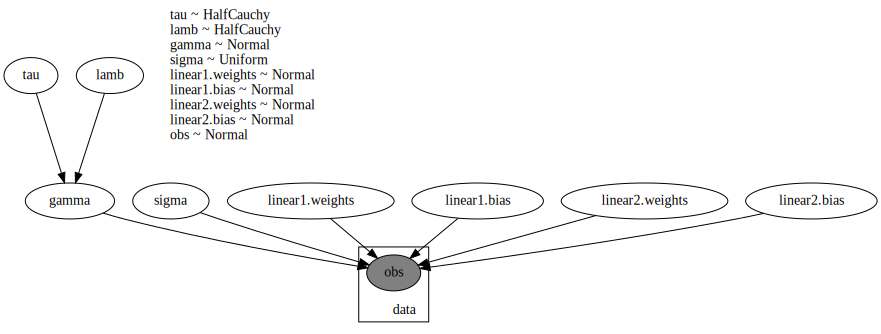

In [5]:
# Define the horseshoe SSVS model
# type = 'm' for 'manual' linear layer, type = 't' for torch.nn.linear
ssvs_model = HorseshoeSSVS(train_embedding.shape[1], 1, type='m', device=device)

pyro.render_model(ssvs_model, model_args=(train_embedding[0], Ytr[0]), render_distributions=True, filename=None)

In [6]:
# Run Markov chains and collect diagnostics
num_samples = 1000
ssvs_mcmc, predictive, diagnostics = inference(config, ssvs_model, None, X_train=train_embedding, Y_train=Ytr, X_test=test_embedding, Y_test=Yte, num_samples=num_samples)

Sample:  50%|████▉     | 497/1000 [1:06:39,  8.38s/it, step size=1.22e-04, acc. prob=0.483]

In [ ]:
plot_forecast(predictive, Yte, "ssvs")